In [67]:
from __future__ import annotations

import sys
import traceback
from pathlib import Path
from typing import Any, List

import numpy as np
import pandas as pd  # type: ignore[import]

PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / "src").is_dir():
    PROJECT_ROOT = PROJECT_ROOT.parent
SRC_ROOT = PROJECT_ROOT / "src"
DATA_ROOT = PROJECT_ROOT / "data" / "processed"

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print(f"Using project root: {PROJECT_ROOT}")
print(f"Data directory: {DATA_ROOT}")

Using project root: D:\Research\nips_reviewing\CategoryLearning\StateBased\CategoryLearning
Data directory: D:\Research\nips_reviewing\CategoryLearning\StateBased\CategoryLearning\data\processed


In [68]:
from src.Bayesian_state.utils.load_config import MODEL_STRUCT
from src.Bayesian_state.utils.state_grid_optimizer import StateModelGridOptimizer

# Select Model
model_choice = "pmh_model"
engine_config = MODEL_STRUCT.get(model_choice)

if engine_config is None:
    raise ValueError(f"Model {model_choice} not found.")

print(f"Loaded configuration for: {model_choice}")

Loaded configuration for: pmh_model


In [69]:
import importlib
import src.Bayesian_state.utils.state_grid_optimizer
import src.Bayesian_state.problems.model
import src.Bayesian_state.inference_engine.bayesian_engine
import src.Bayesian_state.problems.modules.memory

importlib.reload(src.Bayesian_state.inference_engine.bayesian_engine)
importlib.reload(src.Bayesian_state.problems.modules.memory)
importlib.reload(src.Bayesian_state.problems.model)
importlib.reload(src.Bayesian_state.utils.state_grid_optimizer)

from src.Bayesian_state.utils.state_grid_optimizer import StateModelGridOptimizer
from src.Bayesian_state.problems import StateModel

print("Modules reloaded.")

{'base_model': {'modules': {'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {}}}, 'agenda': ['likelihood_mod', '__self__']}, 'default_model': {'modules': {}, 'agenda': ['__self__']}, 'm_model': {'modules': {'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.8, 'gamma': 0.8}}}, 'agenda': ['likelihood_mod', 'memory_mod']}, 'pmh_model': {'modules': {'perception_mod': {'class': 'src.Bayesian_state.problems.modules.perception.PerceptionModule'}, 'hypo_transitions_mod': {'class': 'src.Bayesian_state.problems.modules.hypo_transitions.DynamicHypothesisModule', 'kwargs': {}}, 'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.Dual

In [70]:
import os
import multiprocessing

cpu_count = os.cpu_count()
print(f"Total CPU cores available: {cpu_count}")

# Recommendation: Leave 1-2 cores free for system tasks
recommended_n_jobs = max(1, cpu_count - 2)
print(f"Recommended n_jobs: {recommended_n_jobs}")

Total CPU cores available: 16
Recommended n_jobs: 14


In [71]:
# Initialize Optimizer
optimizer = StateModelGridOptimizer(
    engine_config=engine_config,
    processed_data_dir=DATA_ROOT,
    n_jobs=12 # Adjust based on your CPU cores
)
print("Optimizer initialized.")

Optimizer initialized.


In [72]:
subject_id = 1

def build_subject_dataset(subject_id: int) -> tuple[np.ndarray, np.ndarray, np.ndarray, int]:
    """Load Task2 data and return arrays for a single subject."""
    task2_path = DATA_ROOT / "Task2_processed.csv"
    if not task2_path.exists():
        raise FileNotFoundError(f"Missing processed dataset: {task2_path}")

    learning_data = pd.read_csv(task2_path)
    subject_data = learning_data[learning_data["iSub"] == subject_id]
    if subject_data.empty:
        raise ValueError(f"Subject {subject_id} not found in Task2 dataset")

    condition = int(subject_data["condition"].iloc[0])
    stimulus = subject_data[["feature1", "feature2", "feature3", "feature4"]].to_numpy(dtype=float)
    choices = subject_data["choice"].to_numpy(dtype=float)
    feedback = subject_data["feedback"].to_numpy(dtype=float)

    return stimulus, choices, feedback, condition

try:
    stimulus, choices, feedback, condition = build_subject_dataset(subject_id)
except Exception as exc:  # noqa: BLE001
    print("Dataset preparation failed:", exc)
    traceback.print_exc()
    raise

print(f"Loaded subject {subject_id} with {len(stimulus)} trials (condition {condition}).")
print("First stimulus row:", stimulus[0])
print("Choice / feedback samples:", choices[:3], feedback[:3])
print("Condition", condition)

Loaded subject 1 with 128 trials (condition 1).
First stimulus row: [0.09672187 0.48407559 0.0801764  0.47426191]
Choice / feedback samples: [1. 1. 1.] [1. 1. 1.]
Condition 1


In [73]:

# Example Grid: Optimizing gamma (forgetting) and w0 (background noise)
# 都舍入到小数点后4位
param_grid = {
    "gamma": np.round(np.arange(0.05, 1.0, 0.05), 4).tolist(),
    "w0": np.round(np.arange(0.001, 0.041, 0.002), 4).tolist()
}

print(f"Starting optimization for Subject {subject_id}...")
print(f"Parameter Grid: {param_grid}")

# Run Optimization
# n_repeats: Number of runs per grid point for coarse selection
# refit_repeats: Number of runs for the best parameter set for fine estimation
results = optimizer.optimize_subject(
    subject_id=subject_id,
    param_grid=param_grid,
    n_repeats=16,        
    refit_repeats=128,    
    keep_logs=False
)

print("Optimization complete.")

INFO:cat-learning:Optimizing subject 1: 380 combos * 16 repeats = 6080 tasks


Starting optimization for Subject 1...
Parameter Grid: {'gamma': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95], 'w0': [0.001, 0.003, 0.005, 0.007, 0.009, 0.011, 0.013, 0.015, 0.017, 0.019, 0.021, 0.023, 0.025, 0.027, 0.029, 0.031, 0.033, 0.035, 0.037, 0.039]}


Sub 1 Grid Search: 100%|██████████| 6080/6080 [01:46<00:00, 56.89it/s]
INFO:cat-learning:Refitting best params for subject 1 with 128 repeats.
Sub 1 Refit: 100%|██████████| 128/128 [00:01<00:00, 86.17it/s]


Optimization complete.


In [74]:
# Analyze Results
best_result = results['best']

print("="*40)
print(f"Optimization Results for Subject {subject_id}")
print("="*40)
print(f"Best Parameters: {best_result.params}")
print(f"Best Mean Error: {best_result.mean_error:.6f}")
print(f"Standard Error:  {best_result.std_error:.6f}")
print("-" * 40)

# Convert grid results to DataFrame for easier viewing
grid_data = []
for res in results['grid']:
    row = res.params.copy()
    row['mean_error'] = res.mean_error
    row['std_error'] = res.std_error
    grid_data.append(row)

df_results = pd.DataFrame(grid_data)
df_results = df_results.sort_values('mean_error')

print("\nTop 5 Parameter Combinations:")
print(df_results.head(5))

Optimization Results for Subject 1
Best Parameters: {'gamma': 0.75, 'w0': 0.009}
Best Mean Error: 0.291723
Standard Error:  0.011560
----------------------------------------

Top 5 Parameter Combinations:
     gamma     w0  mean_error  std_error
345   0.90  0.011    0.283424   0.008258
363   0.95  0.007    0.283581   0.010983
370   0.95  0.021    0.284309   0.007612
342   0.90  0.005    0.284570   0.006414
365   0.95  0.011    0.284604   0.009338


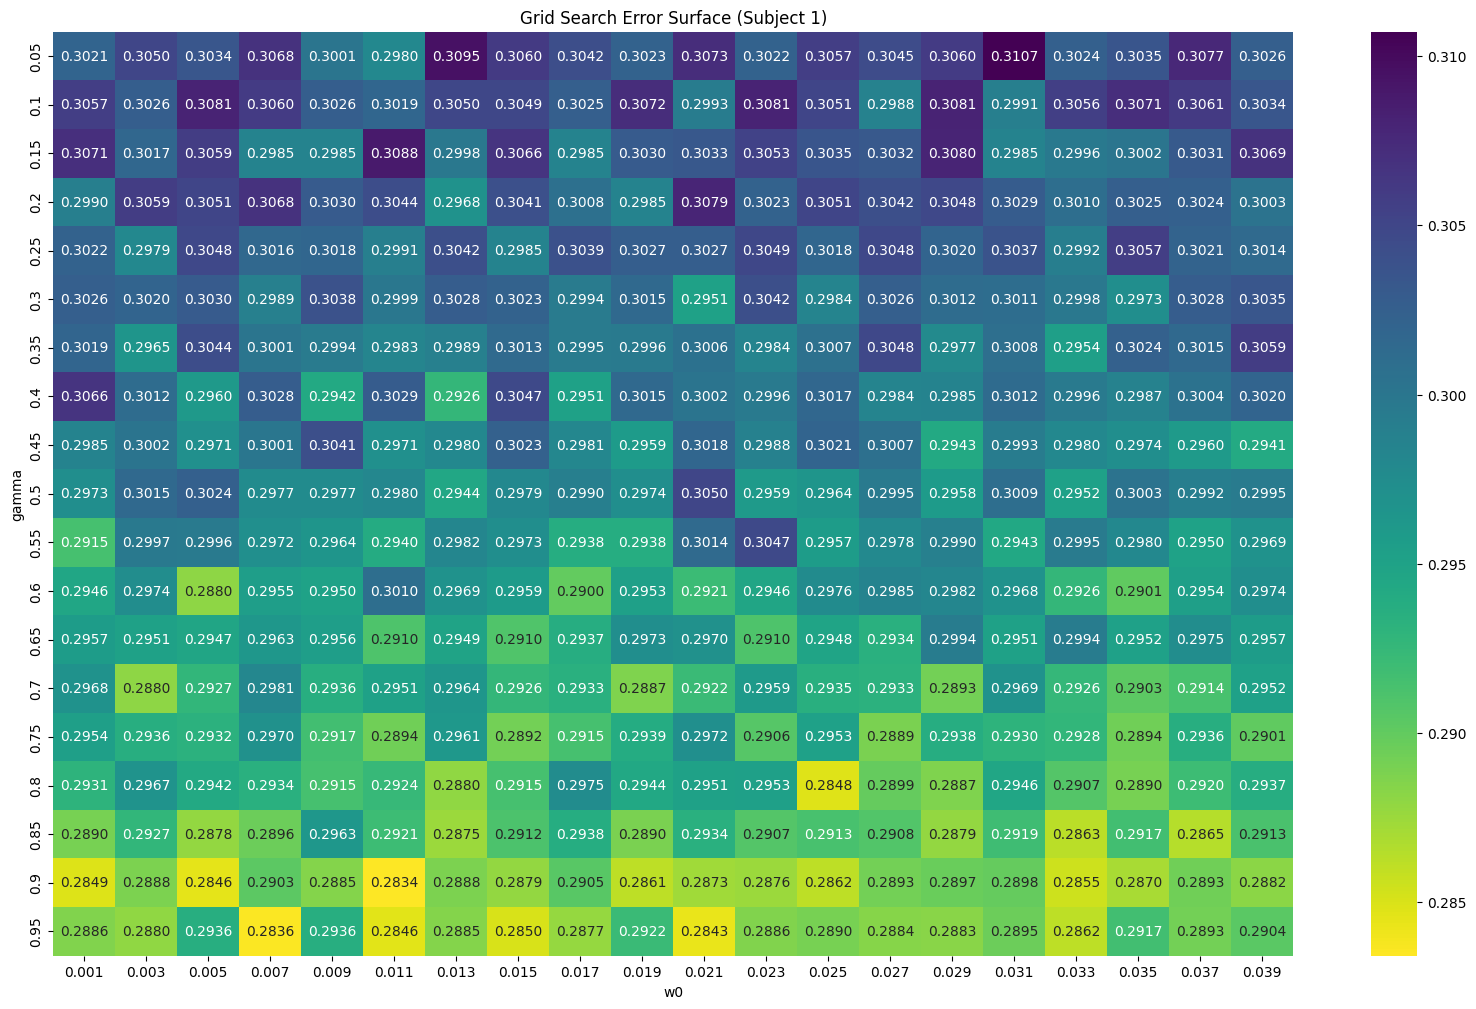

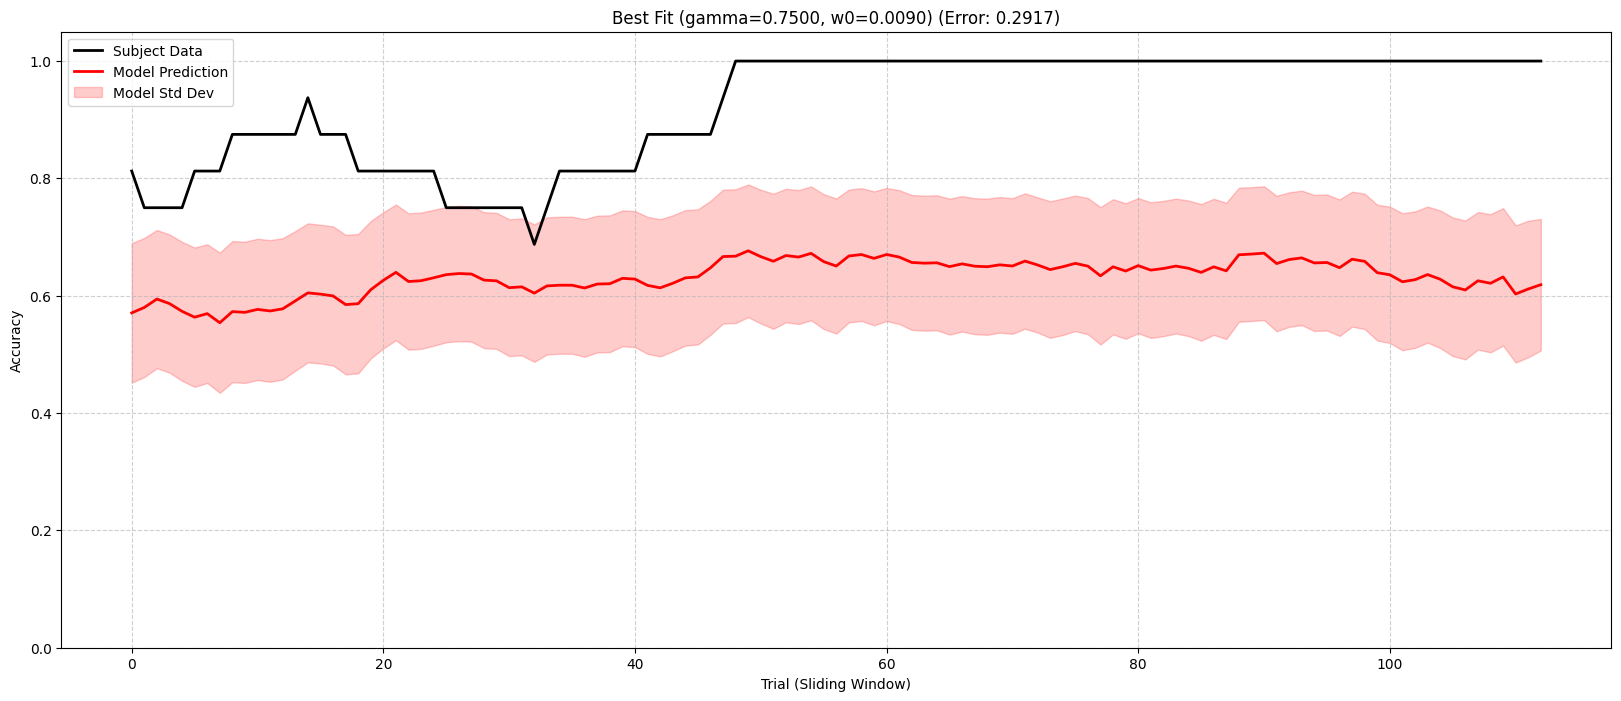

In [75]:
# Visualization (Optional)
import matplotlib.pyplot as plt
import seaborn as sns

# Pivot for heatmap (assuming 2D grid: gamma vs w0)
if "gamma" in df_results.columns and "w0" in df_results.columns:
    pivot_table = df_results.pivot(index="gamma", columns="w0", values="mean_error")
    
    plt.figure(figsize=(20, 12))
    sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap="viridis_r")
    plt.title(f"Grid Search Error Surface (Subject {subject_id})")
    plt.show()

# Plot Best
plot_result = best_result
title_prefix = f"Best Fit (gamma={best_result.params.get('gamma'):.4f}, w0={best_result.params.get('w0'):.4f})"

# Plot Fit Curve
plt.figure(figsize=(20, 8))
metrics = plot_result.metrics
sliding_true = metrics["sliding_true_acc"]
sliding_pred = metrics["sliding_pred_acc"]
sliding_std = metrics["sliding_pred_acc_std"]
trials = np.arange(len(sliding_true))

plt.plot(trials, sliding_true, label="Subject Data", color="black", linewidth=2)
plt.plot(trials, sliding_pred, label="Model Prediction", color="red", linewidth=2)

# Add confidence interval if available
if sliding_std is not None and not np.all(np.isnan(sliding_std)):
    plt.fill_between(
        trials, 
        sliding_pred - sliding_std, 
        sliding_pred + sliding_std, 
        color="red", 
        alpha=0.2,
        label="Model Std Dev"
    )

plt.xlabel("Trial (Sliding Window)")
plt.ylabel("Accuracy")
plt.title(f"{title_prefix} (Error: {plot_result.mean_error:.4f})")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.ylim(0, 1.05)
plt.show()